# Plot Raft CCD Offsset

The goal is to plot a raft with the CCDs offset, which are x, y and an angle.

In [1]:
! eups list -s lsst_distrib

   g047143d79e+efab7f3517 	current w_2024_29 setup


In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
sns.set_context('talk')

In [4]:
from datetime import date
today = date.today()

In [5]:
from astropy.table import join, Table
from astropy.io.ascii import read

data = read('fullRun-2023-06-21.csv')
data['theta'] -= 90.
crop = data['dR']<300.
crop &= (np.abs(data['theta'])<15.)|(np.abs(data['theta']-90)<15.)

data = data[crop]

In [6]:
colors = ['lightgray','k','r']

In [7]:
itl = data['ccd_type'] == 'ITL'
e2v = ~itl

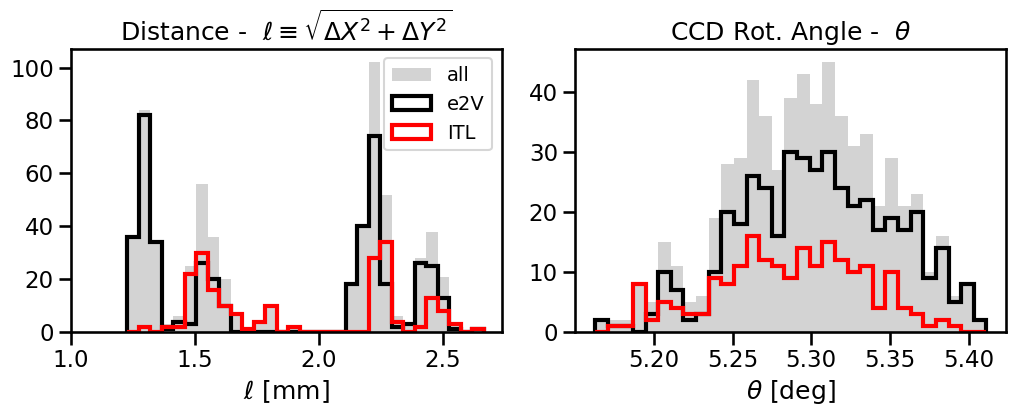

In [8]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(10.5,4.5))
_ = axs[0].hist(data['dR']/1e2,bins=31, color=colors[0],label='all')
# _ = axs[0].hist(np.hypot(deltax,deltay),bins=_[1], color=colors[0],label='all')
_ = axs[0].hist(data['dR'][e2v]/1e2, bins=_[1], histtype='step',lw=3, color=colors[1],label='e2V')
_ = axs[0].hist(data['dR'][itl]/1e2, bins=_[1], histtype='step',lw=3, color=colors[2],label='ITL')

_ = axs[1].hist(data['GRID_THETA']*180/np.pi,bins=31, color=colors[0])
_ = axs[1].hist(data['GRID_THETA'][e2v]*180/np.pi, bins=_[1], histtype='step',lw=3, color=colors[1])
_ = axs[1].hist(data['GRID_THETA'][itl]*180/np.pi, bins=_[1], histtype='step',lw=3, color=colors[2])


axs[0].set_xticks(np.linspace(1,2.5,4))
axs[0].legend(loc=1,fontsize=14)
axs[0].set_xlabel(r'$\ell$ [mm]')
axs[1].set_xlabel(r'$\theta$ [deg]')

axs[0].set_title(r'Distance -  $\ell \equiv \sqrt{\Delta X^2 + \Delta Y^2}$')
axs[1].set_title(r'CCD Rot. Angle -  $\theta$')
fig.tight_layout()
plt.savefig(f'histogram_ccd_offsets_{today}.png',dpi=150)

## Raft Image

In [46]:
dimensions = {'e2v':[4096,4004],'itl':[4072,4000]}

def make_ones(dtype='itl'):
    nx, ny = dimensions[dtype]
    return np.ones((nx,ny))

ccd = make_ones()

In [47]:
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()
det_names = {i: det.getName() for i, det in enumerate(camera)}
det_nums = {det.getName():i for i, det in enumerate(camera)}

print(det_names[98],det_nums['R22_S22'])

R22_S22 98


In [48]:
from lsst.afw.cameraGeom import FOCAL_PLANE, FIELD_ANGLE
det = camera[98]
print(f"{det.getCenter(FIELD_ANGLE) = } (radians)")
print(f"{det.getCenter(FOCAL_PLANE) = } (mm)")

det.getCenter(FIELD_ANGLE) = Point2D(0.0040977554376279432, 0.0040977554376279432) (radians)
det.getCenter(FOCAL_PLANE) = Point2D(42.25, 42.25) (mm)


In [49]:
det.getCenter(FIELD_ANGLE)[0]

0.004097755437627943

(array([  3.,   0.,  16.,   0.,   0.,  36.,   0., 120.,   0.,   3.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

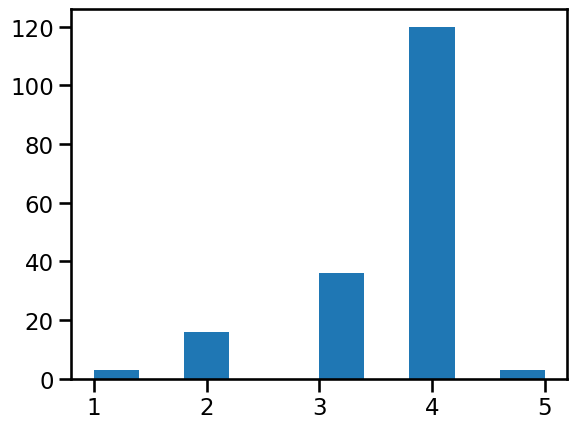

In [50]:
di, ci = np.unique(data['detector'], return_counts=True)
plt.hist(ci)

In [51]:
det.getCenter(FOCAL_PLANE)

Point2D(42.25, 42.25)

In [52]:
data['X0_F'] = [camera[int(di)].getCenter(FOCAL_PLANE)[0] for di in data['detector']]
data['Y0_F'] = [camera[int(di)].getCenter(FOCAL_PLANE)[1] for di in data['detector']]

In [53]:
to_mm = 1./100.
data['GRID_X0']*to_mm

20.990284986449602
42.0542718355139
20.8078445629545
-0.16119426463817502
41.8563406163561
-0.362099904451554
41.6629666010372
21.017773456998597
20.9126772173151
41.989499541146294
20.7670361271285


In [54]:
camera[int(32)].getCenter(PIXELS)

Point2D(2035.5, 1999.5)

In [56]:
from lsst.afw.cameraGeom import PIXELS
to_mm = 1./100.
def convert_pixels_to_focal_plane_mm(x, y, detectorId):
    cen = camera[int(detectorId)].getCenter(PIXELS)
    dy = y-cen[1]
    dx = x-cen[0]
    return dx*to_mm, dy*to_mm

grid_pos_mm = np.array([convert_pixels_to_focal_plane_mm(data['GRID_X0'][i], data['GRID_Y0'][i], data['detector'][i]) for i in range(len(data))])

# focal plane units [mm]
data['GRID_X0_F'] = grid_pos_mm[:,0] + data['X0_F']
data['GRID_Y0_F'] = grid_pos_mm[:,1] + data['Y0_F']

pairs = np.unique(data['pairID'])

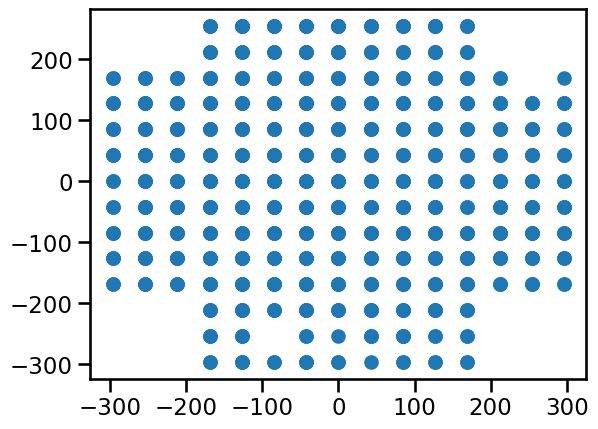

In [57]:
plt.scatter(data['X0_F'],data['Y0_F'])

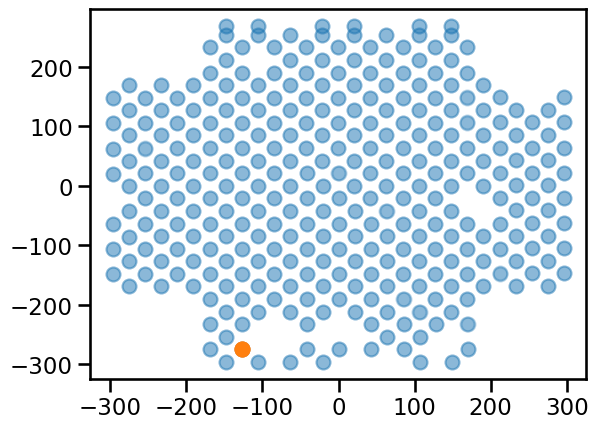

In [58]:
p0 = data['pairID']==2

plt.scatter(data['GRID_X0_F'],data['GRID_Y0_F'],s=100,alpha=0.3)
plt.scatter(data['GRID_X0_F'][p0],data['GRID_Y0_F'][p0],s=100)

In [59]:
detectors = data['detector']
pairs = data['pairID']

deltax, deltay, deltat = [], [], []
for i in range(len(data)):
    did = detectors[i]
    pid = pairs[i]
    mask = pairs==pid
    m0 = mask&(detectors==did)
    m1 = mask&(detectors!=did)
    # print(data[['pairID','detector','GRID_X0_F','GRID_Y0_F']][mask])
    dx = float(data['GRID_X0_F'][m0]-data['GRID_X0_F'][m1])
    dy = float(data['GRID_Y0_F'][m0]-data['GRID_Y0_F'][m1])
    dt = float(data['GRID_THETA'][m0]-data['GRID_THETA'][m1])

    deltax.append(dx)
    deltay.append(dy)
    deltat.append(dt)

deltax = np.array(deltax)
deltay = np.array(deltay)
deltat = np.array(deltat)

(array([  1.,   0.,   0.,   0.,   1.,   1.,   2.,   5.,   3.,  11.,  16.,
         26.,  50.,  71.,  76., 112.,  76.,  71.,  50.,  26.,  16.,  11.,
          3.,   5.,   2.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.22805212, -0.21333908, -0.19862604, -0.183913  , -0.16919996,
        -0.15448692, -0.13977388, -0.12506084, -0.1103478 , -0.09563476,
        -0.08092172, -0.06620868, -0.05149564, -0.0367826 , -0.02206956,
        -0.00735652,  0.00735652,  0.02206956,  0.0367826 ,  0.05149564,
         0.06620868,  0.08092172,  0.09563476,  0.1103478 ,  0.12506084,
         0.13977388,  0.15448692,  0.16919996,  0.183913  ,  0.19862604,
         0.21333908,  0.22805212]),
 <BarContainer object of 31 artists>)

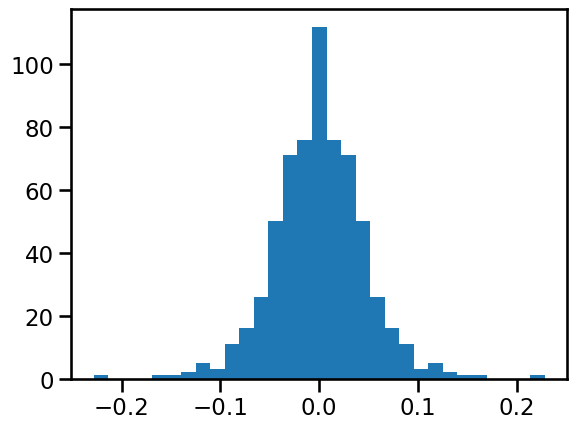

In [60]:
plt.hist(deltax,bins=31)

In [61]:
dx

-0.01570428320135875

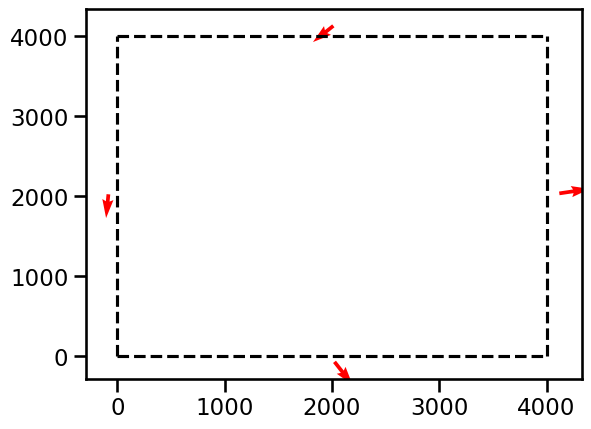

In [62]:
# print(det_names[98],det_nums['R22_S22'])
di = det_nums['R22_S22']
X = np.array(data['GRID_X0'])[detectors==di]
Y = np.array(data['GRID_Y0'])[detectors==di]

dx = deltax[detectors==di]
dy = deltay[detectors==di]

plt.quiver(X, Y, dx, dy,color='r')
plt.plot([0,4000],[0,0],'k--')
plt.plot([0,4000],[4000,4000],'k--')
plt.plot([0.,0.],[0,4000],'k--')
plt.plot([4000.,4000.],[0,4000],'k--')

In [130]:
np.std(dy)

6.727072705964699

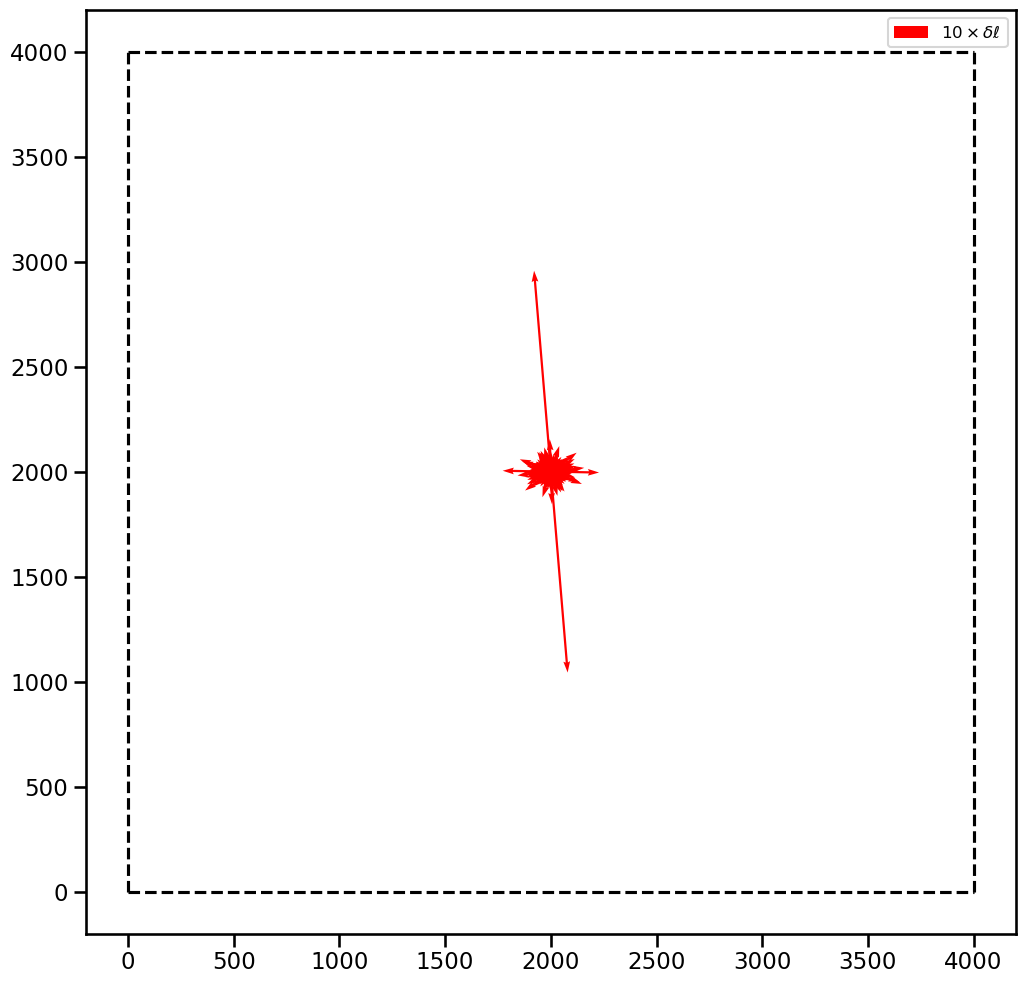

In [128]:
# print(det_names[98],det_nums['R22_S22'])
plt.figure(figsize=(12,12))
di = det_nums['R22_S22']
X = np.array(data['GRID_X0'])
Y = np.array(data['GRID_Y0'])

dx = deltax/to_mm
dy = deltay/to_mm

# plt.quiver(X, Y, dx, dy, color='r', scale=1/10., scale_units='xy', angles='xy', label=r'$10 \times \delta \ell$')
plt.quiver(np.zeros_like(dx)+2000, np.zeros_like(dx)+2000, dx, dy, color='r', scale=1/10., scale_units='xy', angles='xy', label=r'$10 \times \delta \ell$')

plt.plot([0,4000],[0,0],'k--')
plt.plot([0,4000],[4000,4000],'k--')
plt.plot([0.,0.],[0,4000],'k--')
plt.plot([4000.,4000.],[0,4000],'k--')
plt.legend(fontsize=12)

4.56127005187163

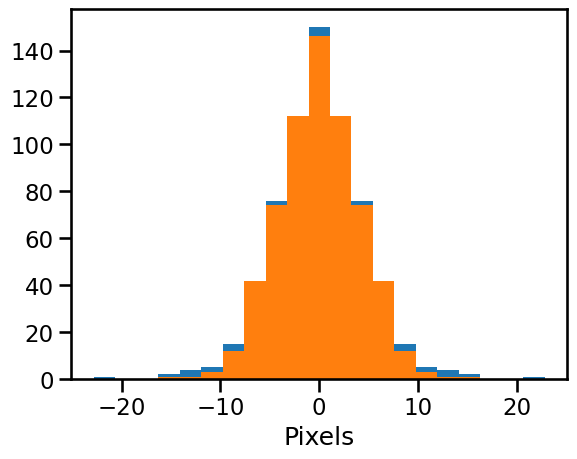

In [68]:
_ = plt.hist(dx,bins=21)
_ = plt.hist(dy,bins=_[1])

plt.xlabel('Pixels')
np.std(dx)

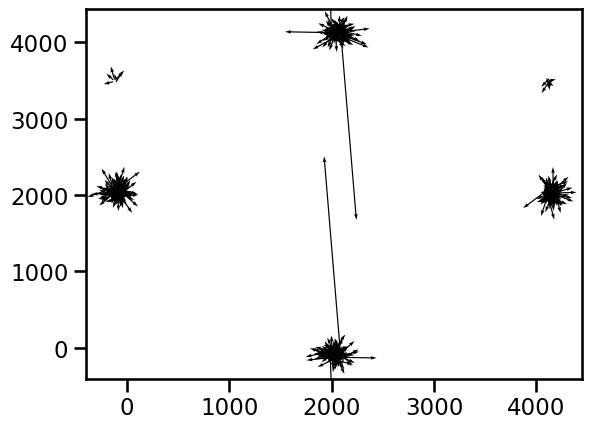

In [65]:
# fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(24,12))

_, idx = np.unique(pairs, return_index=True)
X = np.array(data['GRID_X0'])
Y = np.array(data['GRID_Y0'])
R = np.hypot(X,Y)

dx = deltax/to_mm
dy = deltay/to_mm

# axs[0].scatter(X,Y, c=deltax, vmax=0.1)
# axs[1].scatter(X,Y, c=deltay, vmax=0.1)
# plt.colorbar()
plt.quiver(X, Y, dx, dy)

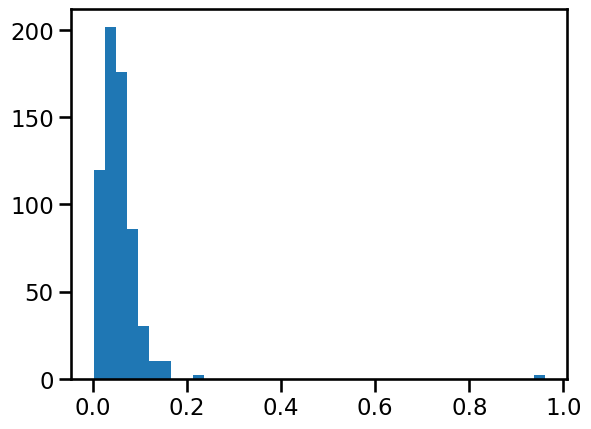

In [27]:
# _ = plt.hist(deltax,bins=41)
# _ = plt.hist(deltay,bins=_[1])
_ = plt.hist(np.hypot(deltax,deltay),bins=41)

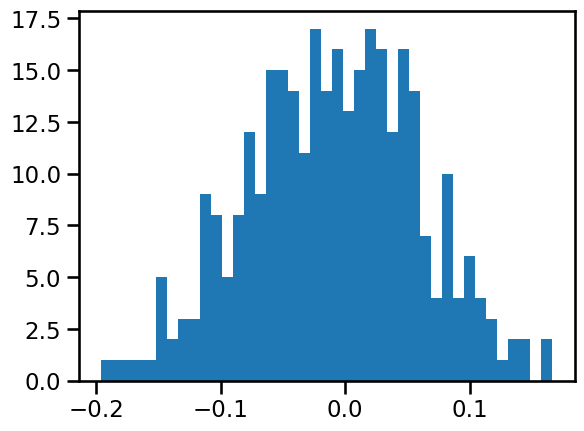

In [28]:
_, idx = np.unique(pairs, return_index=True)
_ = plt.hist(deltat[idx]*(180/np.pi),bins=41)

In [29]:
# deltax

In [69]:
calibration = []
for i in range(4):
    g1 = data['group'] == i
    x0 , y0 = np.nanmedian(data['GRID_X0'][g1]), np.nanmedian(data['GRID_Y0'][g1])
    err_x0 , err_y0 = np.nanstd(data['GRID_X0'][g1]), np.nanstd(data['GRID_Y0'][g1])
    calibration.append([x0,y0,err_x0,err_y0])

In [70]:
calibration[0]

[2046.83729044134, 4142.10144956136, 31.192578411674297, 34.998386788792494]

In [71]:
deltar = np.hypot(deltax,deltay)

In [173]:
def get_label(x, units='pixel'):
    return r'$\sigma: %.2f$ %s'%(np.std(x), units)

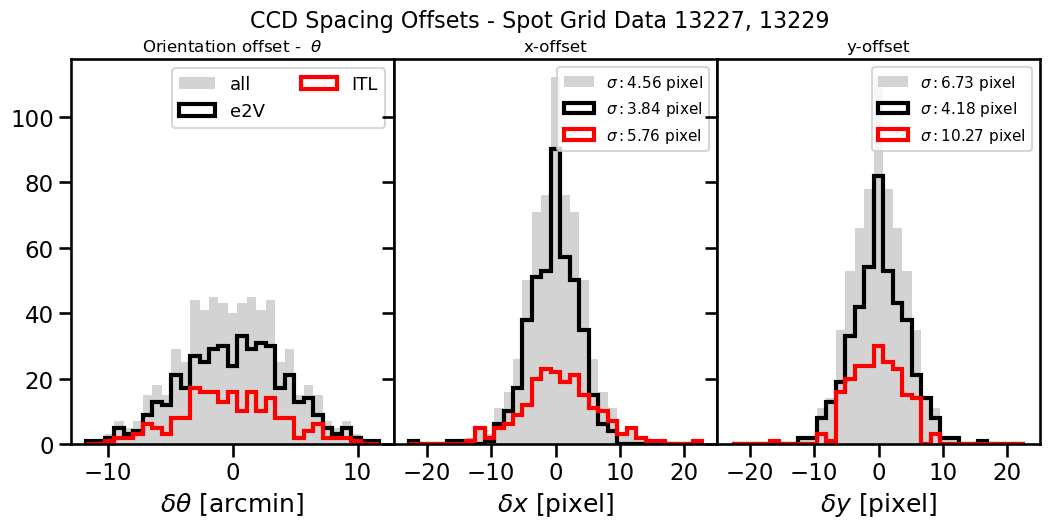

In [174]:
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(12.5,5), sharey='all')
fig.subplots_adjust(wspace=0.0)

_ = axs[1].hist(deltax/to_mm,bins=31, color=colors[0],label=get_label(deltax/to_mm))
# _ = axs[0].hist(np.hypot(deltax,deltay),bins=_[1], color=colors[0],label='all')
_ = axs[1].hist(deltax[e2v]/to_mm, bins=_[1], histtype='step',lw=3, color=colors[1],label=get_label(deltax[e2v]/to_mm))
_ = axs[1].hist(deltax[itl]/to_mm, bins=_[1], histtype='step',lw=3, color=colors[2],label=get_label(deltax[itl]/to_mm))


_ = axs[2].hist(deltay/to_mm,bins=_[1], color=colors[0],label=get_label(deltay/to_mm))
# _ = axs[0].hist(np.hypot(deltax,deltay),bins=_[1], color=colors[0],label='all')
_ = axs[2].hist(deltay[e2v]/to_mm, bins=_[1], histtype='step',lw=3, color=colors[1],label=get_label(deltay[e2v]/to_mm))
_ = axs[2].hist(deltay[itl]/to_mm, bins=_[1], histtype='step',lw=3, color=colors[2],label=get_label(deltay[itl]/to_mm))

_ = axs[0].hist(deltat*180*60/np.pi,bins=31, color=colors[0],label='all')
_ = axs[0].hist(deltat[e2v]*180*60/np.pi, bins=_[1], histtype='step',lw=3, color=colors[1],label='e2V')
_ = axs[0].hist(deltat[itl]*180*60/np.pi, bins=_[1], histtype='step',lw=3, color=colors[2],label='ITL')

axs[0].legend(loc=1,fontsize=13, ncol=2)
axs[1].legend(loc=1,fontsize=11)
axs[2].legend(loc=1,fontsize=11)

axs[1].set_xlabel(r'$\delta x$ [pixel]')
axs[2].set_xlabel(r'$\delta y$ [pixel]')
axs[0].set_xlabel(r'$\delta \theta$ [arcmin]')
axs[1].set_xticks(np.linspace(-20,20,5))
axs[2].set_xticks(np.linspace(-20,20,5))


fig.suptitle(r'CCD Spacing Offsets - Spot Grid Data 13227, 13229', fontsize=16)
axs[1].set_title('x-offset', fontsize=12)
axs[2].set_title('y-offset', fontsize=12)
axs[0].set_title(r'Orientation offset -  $\theta$', fontsize=12)
# fig.tight_layout()
plt.savefig(f'histogram_ccd_offsets_{today}.png',dpi=150, bbox_inches = 'tight')

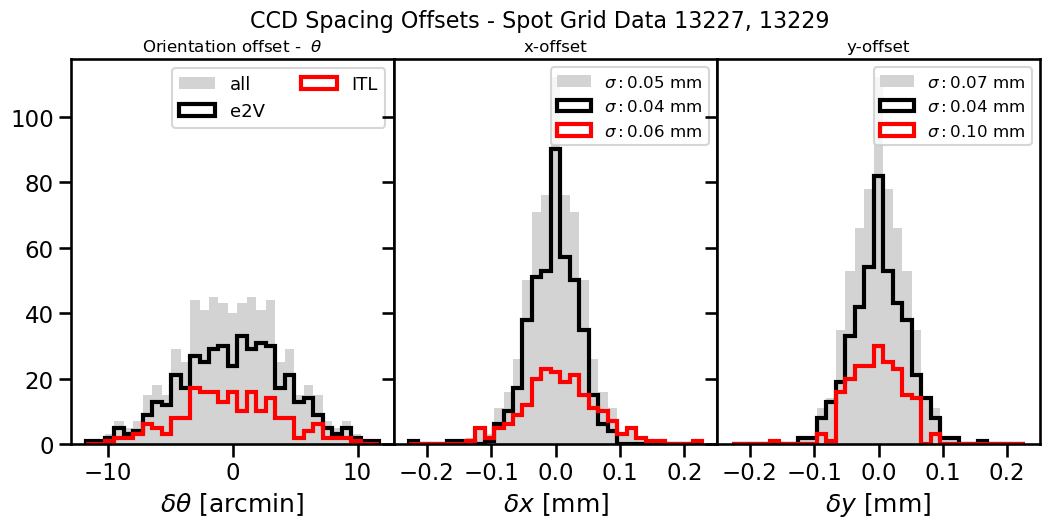

In [170]:
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(12.5,5), sharey='all')
fig.subplots_adjust(wspace=0.0)

_ = axs[1].hist(deltax,bins=31, color=colors[0],label=get_label(deltax, units='mm'))
# _ = axs[0].hist(np.hypot(deltax,deltay),bins=_[1], color=colors[0],label='all')
_ = axs[1].hist(deltax[e2v], bins=_[1], histtype='step',lw=3, color=colors[1],label=get_label(deltax[e2v], units='mm'))
_ = axs[1].hist(deltax[itl], bins=_[1], histtype='step',lw=3, color=colors[2],label=get_label(deltax[itl], units='mm'))


_ = axs[2].hist(deltay,bins=_[1], color=colors[0],label=get_label(deltay, units='mm'))
# _ = axs[0].hist(np.hypot(deltax,deltay),bins=_[1], color=colors[0],label='all')
_ = axs[2].hist(deltay[e2v], bins=_[1], histtype='step',lw=3, color=colors[1],label=get_label(deltay[e2v], units='mm'))
_ = axs[2].hist(deltay[itl], bins=_[1], histtype='step',lw=3, color=colors[2],label=get_label(deltay[itl], units='mm'))

_ = axs[0].hist(deltat*180*60/np.pi,bins=31, color=colors[0],label='all')
_ = axs[0].hist(deltat[e2v]*180*60/np.pi, bins=_[1], histtype='step',lw=3, color=colors[1],label='e2V')
_ = axs[0].hist(deltat[itl]*180*60/np.pi, bins=_[1], histtype='step',lw=3, color=colors[2],label='ITL')

axs[0].legend(loc=1,fontsize=13, ncol=2)
axs[1].legend(loc=1,fontsize=12)
axs[2].legend(loc=1,fontsize=12)

axs[1].set_xlabel(r'$\delta x$ [mm]')
axs[2].set_xlabel(r'$\delta y$ [mm]')
axs[0].set_xlabel(r'$\delta \theta$ [arcmin]')
axs[1].set_xticks(np.linspace(-20*to_mm,20*to_mm,5))
axs[2].set_xticks(np.linspace(-20*to_mm,20*to_mm,5))


fig.suptitle(r'CCD Spacing Offsets - Spot Grid Data 13227, 13229', fontsize=16)
axs[1].set_title('x-offset', fontsize=12)
axs[2].set_title('y-offset', fontsize=12)
axs[0].set_title(r'Orientation offset -  $\theta$', fontsize=12)
# fig.tight_layout()
plt.savefig(f'histogram_ccd_offsets_{today}_mm.png',dpi=150, bbox_inches = 'tight')

In [177]:
np.std(np.hypot(deltax,deltay))/to_mm

5.972548032561167

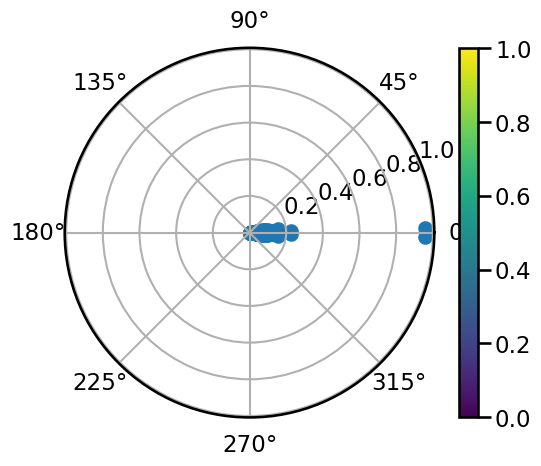

In [121]:
# Create a polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
im = ax.scatter(deltat*180/np.pi, deltar)
fig.colorbar(im)